# Photon-to-axion/dark-photon coupling solver in the case of costant magnetic field and in one halo. 

(SEE THE GENERAL NOTEBOOK FOR A MORE PRECISE TREATMENT OF THE MATTER)

Here we want to solve the photon-to-axion or the photon-to-dark_photon conversion equation in the case we are in an halo, with a certain halo model which gives the function $n_e(r)$ that should be mapped into $n_e(z)$ where $z$ is the axis representing the photon trajectory.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_ivp, ode
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import quad
import math


#OdeintW - wrapper to solve ODE with complex terms.
#import odeintw 
#from odeintw import odeintw


# Visual settings
%config InlineBackend.figure_format='retina'
%matplotlib inline

if '/Library/TeX/texbin/' not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
    
# Latex font
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors
plt.rcParams['figure.figsize'] = [9,7]  # Adjust the size as needed for the plots
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Want to study photon-to-axion or photon-to-dark-photon?

dark_photon = False #Set False if you want to work with axion

In [3]:
####################################
# Natural unit conversions
####################################

#We express all the quantities in eV
GeV = 1 
MeV = 1e-3
keV = 1e-6
eV  = 1e-9
meV = 1e-12 

#Units:
Kg     = 5.609 * 1e35 * eV
meter  = 5.07 * 1e6 * eV**-1
cm     = 1e-2 * meter
Km     = 1e3 * meter
Mpc    = 1.564 * 1e29 * eV**-1
second = 1.5192 * 1e15 * eV**-1
Hz     = 1/second


Gauss  = 1.95 * 1e-2 * eV**2
Joule  = 6.242 * 1e18 * eV  

#Constants
AlphaEM           = 1/137
H_0               = 67.66 * Km/second / Mpc
ElementaryCharge  = np.sqrt(4 * np.pi * AlphaEM);
mass_electron     = 9.109 * 1e-31 * Kg
mass_proton       = 1.672 * 1e-27 * Kg
numerical_density = 1/cm**3


In [4]:
########################################
# Specify parameters of the model
########################################

m_a   = 3e-13 * eV# Axion mass in eV
g_agg =  1e-10 * (GeV)**-1 #5e-11 * (GeV)**-1 # Axion photon-coupling in (GeV)^-1
nu    = 145 * 10**9 * Hz # Frequency in Hz 
omega = 2.*np.pi*nu # Angular frequency in Hz

if dark_photon:
    eps   = 1e-5 #photon-dark photon coupling “natural” values in the range 1e-13 - 10e-2 eV 



In [38]:
########################################
# Specify the halo model
########################################

# Halo setting 

rvir  = 2
rmin  = 0.2
chord_lenght = 2*np.sqrt(rvir**2 - rmin**2)
phii  = np.arcsin(rmin / rvir) 

# Halo model function

r_barr = rvir

def ne(r,r_bar): 
    """"
    A toy model for n_e(r)
    """
    C = (m_a**2 * mass_electron) / (ElementaryCharge**2)
    r = np.asarray(r)
    result = np.zeros_like(r)
    
    mask1 = (r > rvir)
    mask2 = (r <= rvir)
    
    result[mask1] = 0
    result[mask2] =  0.35*C * (r/r_bar)**(-2) 
    
    return result


In [39]:
########################################
# Mapping the halo model on the chord defined by the trajectory (line of sights) and setting the interval of integration
########################################

z_num      = 5000001 #steps number
z_num_half = 2500001



r_val_on_trj_pt1 = np.linspace(rvir, rmin, z_num_half) #First half-set of r values on the chord defined by the trajectory 
r_val_on_trj_pt2 = np.linspace(rmin, rvir, z_num_half) #Second half-set of r values on the chord defined by the trajectory 
r_val_on_trj = np.concatenate([r_val_on_trj_pt1[:], r_val_on_trj_pt2[1:] ])

z_chord = np.sqrt(r_val_on_trj**2 - rmin**2)

z_thr =np.zeros_like(r_val_on_trj)  #Here we work in units of Delta_ag Mpc, i.e. with \tilde{z} = Delta_{ag} Mpc z_adimensional

for i in range(z_num):
    if i < z_num_half:
        z_thr[i] = -z_chord[i]+chord_lenght/2 #In the case you want the interval between -chord_lenght/2 and +chord_lenght/2, cancel chord_lenght/2 in the eqn
    else:
        z_thr[i] = z_chord[i]+chord_lenght/2

z_0 =  z_thr[np.argmin(np.abs(z_thr - 1))]   #Just a pivotal scale. Set to 1 for convenience
print("z_0 = ",z_0 )
    
#Here we associate the values of ne(r_val_on_trj) with the value of z_chord
ne_values_chord = ne(r_val_on_trj, r_barr)
n_e = interp1d(z_thr, ne_values_chord, kind='linear', bounds_error=False, fill_value="extrapolate")

z_0 =  0.9999998487710471


In [40]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################


#Note: we decided to work with \Delta_a and \Delta_\parallel defined without the minus sign. It is totally equivalent and the solution does not change.

def Delta_a(z):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 


def m2_g(z):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return   ElementaryCharge**2 * 1/mass_electron * n_e(z) #in eV units 


def B_T(z):
    """
    Transverse magnetic field
    """
    return  1 * 1e-6 * Gauss  #in \mu G 


def Delta_parallel(z):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_g(z) /(2* omega)


if dark_photon:
    def Delta_ag(z):
        return eps*Delta_a(z)
else:
    def Delta_ag(z):
        """
        Axion-photon coupling term
        Delta_{a\gamma} = g_{a\gamma\gamma}/2 B_T(z)
        """
        return g_agg/2 * B_T(z)


def Delta_osc(z): 
    return np.sqrt((Delta_a(z) - Delta_parallel(z))**2 + 4 * (Delta_ag(z))**2)

def delta_m2(z):
    """
    Differences between squared m_photon and m_a
    """
    return ( m2_g(z)-m_a**2)/(2*omega)

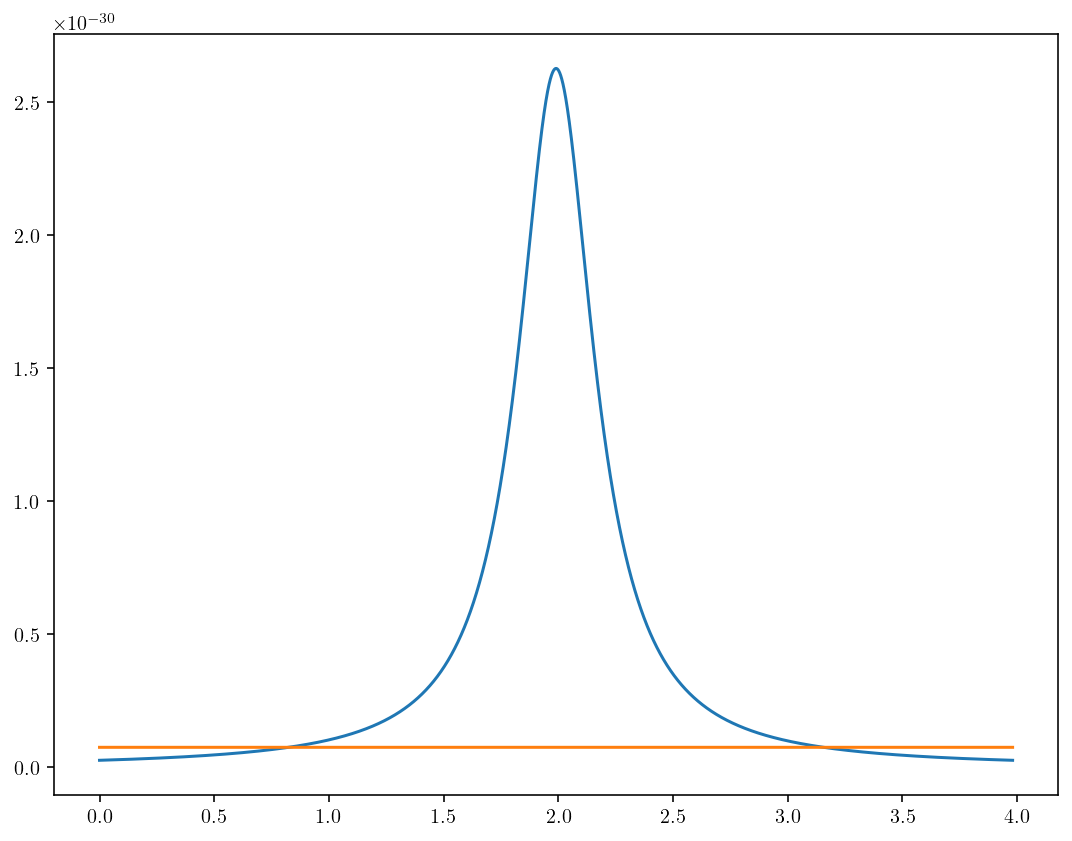

In [41]:
# Preliminary plot to check if resonance happens in this configuration

plt.plot(z_thr , Delta_parallel(z_thr) )
plt.plot(z_thr, Delta_a(z_thr)* np.ones_like(z_thr))

In [42]:
# Indeces and values at first and second resonance, and at the critical point

epsilon = 1e-100
relative_diff = np.abs(Delta_parallel(z_thr) - Delta_a(z_thr)) / (np.abs(Delta_parallel(z_thr)) + np.abs(Delta_a(z_thr)) + epsilon) #Checking the relative difference would be finest
indices = np.where(relative_diff < 1e-6)[0]
indices

index_res1 = indices[0]
index_res2 = indices[-1]
index_crit = int(indices[0] + (indices[-1]-indices[0])/2)

z_res1 = z_thr[index_res1]
z_res2 = z_thr[index_res2]
z_crit = z_thr[index_res1]+ (z_thr[index_res2]-z_thr[index_res1])/2

In [43]:
#Computing the derivative of Delta_parallel and the factor gamma

dDelta_parallel = np.abs(np.gradient(Delta_parallel(z_thr), z_thr)) 

gamma_factor = (Delta_ag(z_thr))/(dDelta_parallel)
print('gamma at first res = ', gamma_factor[index_res1])
print('gamma at second res =' , gamma_factor[index_res2])
print('gamma at critical point =' , gamma_factor[index_crit])

gamma at first res =  7.799281818408722e-06
gamma at second res = 7.79928181805063e-06
gamma at critical point = inf


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_21083/4172303352.py:5: RuntimeWarning: divide by zero encountered in divide
  gamma_factor = (Delta_ag(z_thr))/(dDelta_parallel)


In [44]:
#Computing the probability à la C. Mondino, and comparing it with 2\pi\gamma

log = np.log(m2_g(z_thr))
derivative = np.abs(np.gradient(log, z_thr))**-1

if dark_photon:
    prob_Mondino  = (np.pi * eps**2 * m_a**2/omega ) * derivative[index_res1]/Delta_ag(z_res1)  #Here the resonance happens at z_shift, then you need the index of it
else:
    prob_Mondino  = omega * np.pi * g_agg**2 * B_T(z_thr[index_res1])**2 / m_a**2 * derivative[index_res1]/Delta_ag(z_res1)  #Here the resonance happens at z_shift, then you need the index of it

print("2*pi*gamma is",  2*np.pi*gamma_factor[index_res1])
print("Mondino's probability is",  prob_Mondino)

2*pi*gamma is 4.900433292797857e-05
Mondino's probability is 4.900425617226986e-05


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_21083/2834222385.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  derivative = np.abs(np.gradient(log, z_thr))**-1


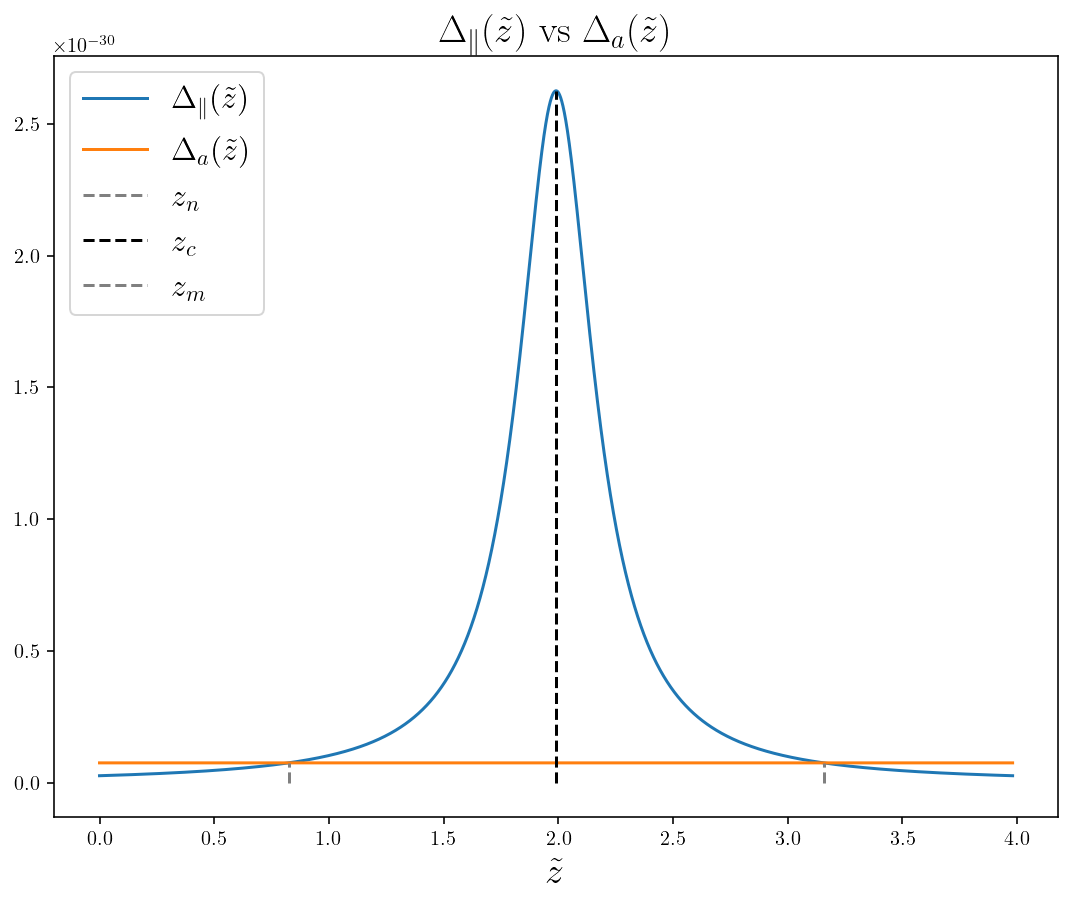

In [45]:
#Plotting Delta_parallel and Delta_a to check where resonance happens. 

plt.plot(z_thr, Delta_parallel(z_thr), label=r'$\Delta_\parallel(\tilde{z})$')
plt.plot(z_thr, Delta_a(z_thr) * np.ones_like(z_thr), label=r'$\Delta_a(\tilde{z})$')

z_n_line = plt.vlines(z_res1, 0, Delta_a(z_res1), linestyle='dashed', color='gray', label=r'$z_n$')
z_c_line = plt.vlines(z_crit, 0, Delta_parallel(z_crit), linestyle='dashed', color='black', label=r'$z_c$')
z_m_line = plt.vlines(z_res2, 0, Delta_a(z_res2), linestyle='dashed', color='gray', label=r'$z_m$')

plt.title(r'$\Delta_\parallel(\tilde{z})$ vs $\Delta_a(\tilde{z})$', fontsize=19)
plt.xlabel(r'$\tilde{z}$', fontsize=19)

plt.legend(fontsize=16, loc='upper left')

plt.show()

In [46]:
#Defining the solver for the photon-to-axion equation

def master_eq_LZ_1(z,S): 
    """ Master equation """
    S = np.asarray(S, dtype=np.complex128)
    ax, f = S
    dSdz = [f, -1j * (Delta_parallel(z) - Delta_a(z))/(Delta_ag(z)) * f  - ax]
    return np.array(dSdz, dtype=np.complex128)

#Initial values
z_init = z_thr[0]
ic_LZ = np.array([ 0, -1j ], dtype=np.complex128)

In [47]:
#Solving the for a spiecific value of z_bar

sol_LZ_1_increasing_decreasing =  solve_ivp( lambda z, S: master_eq_LZ_1(z, S), (z_thr[0], z_thr[-1]), ic_LZ, method='DOP853', t_eval=z_thr, rtol=1e-10, atol=1e-12)


#Squaring to obtain the probability
p_LZ_1_increasing_decreasing =np.abs(sol_LZ_1_increasing_decreasing.y[0])**2 


In [48]:
#Averaging the probability from the second resonance point on, in order to obtain a mean value: 
P_mean_value_2nd_res = np.average(p_LZ_1_increasing_decreasing[index_res2 : ])
print(P_mean_value_2nd_res)

0.00019178075071654005


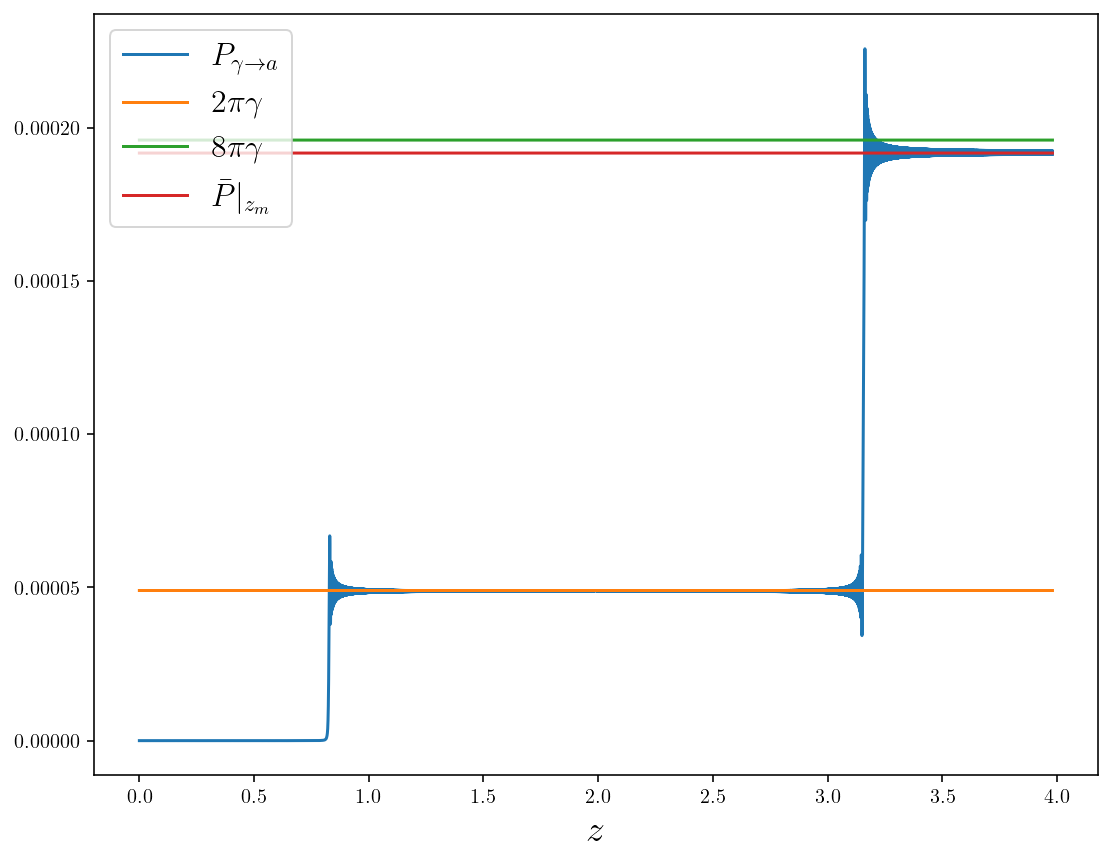

In [49]:
#Plotting the solution
plt.plot(z_thr, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.plot(z_thr, 2*np.pi*gamma_factor[index_res1]*np.ones_like(z_thr), label=r'$2\pi\gamma$')
plt.plot(z_thr, 8*np.pi*gamma_factor[index_res1]*np.ones_like(z_thr), label=r'$8\pi\gamma$')
plt.plot(z_thr,P_mean_value_2nd_res*np.ones_like(z_thr), label=r'$\bar{P}|_{z_m}$')
plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=16, loc='upper left')

For multiple resonance cases there are Quantum Mechanics effect of interference between the waves. In the paper by Brahma et al. (https://arxiv.org/abs/2308.08586) these phase effects are studied. 
The proposed equation for multiple level crossing is

$ P_{\gamma \mapsto a} = \sum_n (2\pi \gamma_n) + 2 \sum_{n<m} \sqrt{(2\pi\gamma_n) (2\pi \gamma_m) } \cos{\Phi_{nm}} $, 

where $\Phi_{nm}$ is a certain phase: 

$\Phi_{nm} = \Phi(z_n) - \Phi(z_m) +\frac{\pi}{4} (\sigma_n-\sigma_m)$

where $\Phi(z)$ is defined to be

$\Phi(z) = \int_{z_i}^{z} (\Delta_\parallel(z) - \Delta_a) dz = \int_{\tilde{z}_i}^{\tilde{z}} d\tilde{z}'_A \, \frac{\Delta_\parallel(\tilde{z}') - \Delta_a}{\Delta_{a\gamma}}$

and

$\sigma(z) = \text{sign}\left[\Phi''(z)\right] = \text{sign}\left[\Delta'_\parallel(z)\right]$.

For two resonance points and in our case of linear increasing-decreasing we have

$\Phi_{nm} = \int_{z_m}^{z_n} \ (\Delta_\parallel(z) -\Delta_a) dz -\frac{\pi}{2} = \frac{1}{2} 2\bar{z} \frac{\Delta_a}{z_0} \bar{z} -\frac{\pi}{2}$.

From the probability equation, being $\cos{\Phi_{nm}}$ maximum in 1, minumum in -1 and on average 0 we get that, in our case of two resonance points ($n=1,2$) where $\gamma_n = \gamma_m$: 

1) Maximum at: $2\pi\gamma (1+1+2) = 4 (2\pi\gamma)$

2) Mean at: $2\pi\gamma (1+1+0) = 2 (2\pi\gamma)$

3) Minum at: $2\pi\gamma (1+1-2) = 0$


In [50]:
# Computing Phi_nm: 

integral, error = quad(delta_m2, z_res2, z_res1) # Integrating Delta_\parallel - Delta_a from z_res1 to z_res2
area = (-1)/(Delta_ag(z_res1)) * integral #Renormalized integral by 1/(Delta_ag(z_res1)), as we did for the ODE solver.

print(f"Area = {area}, enstimated error: {error}")

phi_nm = area - np.pi/2 #this is \Phi_nm
factor = 1+1+2*np.cos(phi_nm) #P = 2\pi\gamma x factor
print('Probability factor = ', factor)
print('Area/2pi = ', area/(2*np.pi))


Area = 1329969.964952863, enstimated error: 1.1512012811244385e-34
Probability factor =  3.923760070802386
Area/2pi =  211671.29408600295


In [51]:
#From the probability at the second resonance point we can compute the numerical \Phi_nm and the numerical factor 

numerical_phase = np.arccos( (P_mean_value_2nd_res - 4*np.pi*gamma_factor[index_res2])/(4*np.pi*gamma_factor[index_res2]) )
numerical_factor = 1+1+2*np.cos(numerical_phase)
print('Numerical prob factor = ', numerical_factor)

Numerical prob factor =  3.9135468083445724


In [52]:
error_2nd_prob = np.abs((numerical_factor-factor)/factor)
print('Error num vs ana = ', error_2nd_prob)


Error num vs ana =  0.002602927363936643


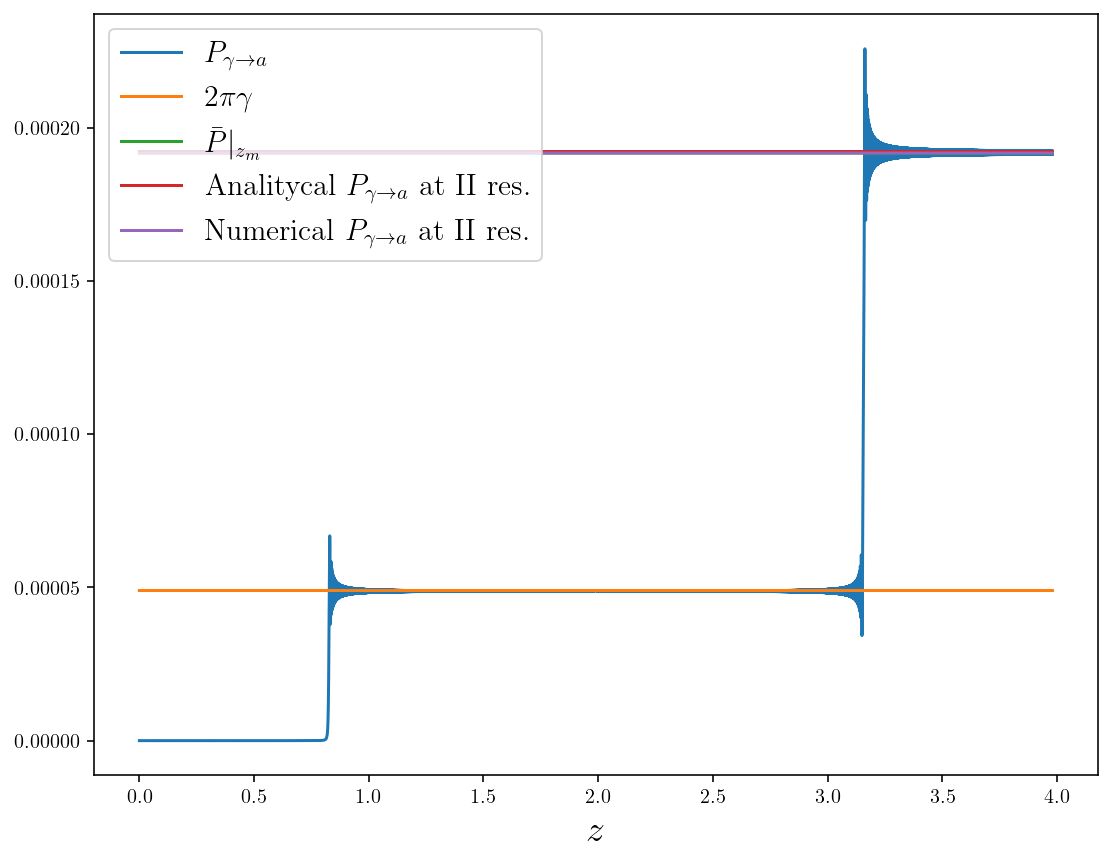

In [53]:
#Plotting the solution
plt.plot(z_thr, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.plot(z_thr, 2*np.pi*gamma_factor[index_res1]*np.ones_like(z_thr), label=r'$2\pi\gamma$')
plt.plot(z_thr,P_mean_value_2nd_res*np.ones_like(z_thr), label=r'$\bar{P}|_{z_m}$')
plt.plot(z_thr,2*np.pi*gamma_factor[index_res1]*np.ones_like(z_thr) * factor, label=r'Analitycal $P_{\gamma \rightarrow a}$ at II res.') #Analytical probability at the second resonance point
plt.plot(z_thr,2*np.pi*gamma_factor[index_res1]*np.ones_like(z_thr) * numerical_factor, label=r'Numerical $P_{\gamma \rightarrow a}$ at II res.') #Numerical probability at the second resonance point

plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=15, loc='upper left')
